In [1]:
"""This project is aimed to identified the person of interest in Enron scandal.

In 2000, Enron was one of the largest companies in the United States.
By 2002, it had collapsed into bankruptcy due to widespread corporate fraud.
In the resulting Federal investigation, a significant amount of typically
confidential information entered into the public record, including tens of
thousands of emails and detailed financial data for top executives.
In this project, I will try to build a detecitve model to identify the
person of interest in Enron scandal, based on financial and email data
made public as a result of the Enron scandal.
"""
import warnings
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data, test_classifier
from time import time
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.exceptions import UndefinedMetricWarning
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression

/home/yedthon/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/yedthon/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
np.random.seed(401)
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=UndefinedMetricWarning) 
%matplotlib inline

In [3]:
def minmax_df(df):
    """Scale the features to 0-1 range by min-max scaling."""
    minmax_features = []
    for i in df:
        if i not in ["poi", "raction_from_poi_to_this_person",
                     "fraction_from_this_person_to_poi", "fraction_shared_receipt_with_poi"]:
            minmax_features.append(i)
    minmax_scaler = MinMaxScaler()
#     std_scaler = StandardScaler()
    minmax_scale_df = df.copy()
#     std_scale_df = df.copy()
    minmax_scale_df[minmax_features] = minmax_scaler.fit_transform(minmax_scale_df[minmax_features])
    # std_scale_df[minmax_features] = std_scaler.fit_transform(minmax_scale_df[minmax_features])
    return minmax_scale_df

In [4]:
def get_train_test(df, features_list=None):
    """Get train and test dataset of features and labels.

    Args:
        df: dataset in dataframe format.
        features_list: features used in training classifier.
    """
    labels = df['poi']
    if features_list == None:
        features = df.drop('poi', axis=1)
    else:
        if "poi" in features_list:
            features_list.remove("poi")
        features = df[features_list]
    features_train, features_test, labels_train, labels_test = \
        train_test_split(features, labels, test_size=0.3, random_state=42)
    return features_train, features_test, labels_train, labels_test

In [5]:
def random_forest_classifier(df, features_list=None, weighted=False):
    """Return best random forest classifier by GridSearchCV.
    
    Args:
        df: dataset in dataframe format.
        features_list: features used in training classifier.
        weighted: True will use f1_weighted score to evaluate classifier
            for catch more True value in imbalance label,
            otherwise use f1 score.
    """
    if features_list is None:
        features_list = [i for i in df.drop('poi', axis=1)]
        
    features_train, features_test, labels_train, labels_test = get_train_test(df, features_list=features_list)
    
#     def custom_score(y_true,y_pred):
#         if precision_score(y_true,y_pred):
#             score = f1_score(y_true,y_pred)
#             print("precision %s" % score)
#         else:
#             score = recall_score(y_true,y_pred)
#             print("recall %s" % score)
#         return score
    if weighted:
        scoring = "f1_weighted"
    else:
        scoring = "f1"
    
    param_grid = {
        'n_estimators': list(range(50, 201, 25)),
        'max_depth': list(range(3, 7))
        
    }
    
    clf = RandomForestClassifier(random_state=42, class_weight="balanced",
                                 oob_score=True, min_samples_leaf=2,
                                 n_jobs=-1)

    clf = GridSearchCV(clf, param_grid, scoring=scoring, verbose=0)
#     clf = GridSearchCV(clf, param_grid, scoring=make_scorer(custom_score, greater_is_better=True))
    
    print("Fitting the classifier to the training set")
    t0 = time()
    clf.fit(features_train, labels_train) 
    print("done in %0.3fs" % (time() - t0))
    print(clf.best_estimator_)
    clf = clf.best_estimator_
    
    # Quantitative evaluation of the model quality on the training set
    print("Predicting on the training set")
    t0 = time()
    train_pred = clf.predict(features_train)
    print(("Done in %0.3fs" % (time() - t0)))

    print((classification_report(labels_train, train_pred)))
    print((confusion_matrix(labels_train, train_pred)))
    
    # Quantitative evaluation of the model quality on the test set
    print("Predicting on the testing set")
    t0 = time()
    pred = clf.predict(features_test)
    print(("Done in %0.3fs" % (time() - t0)))

    print((classification_report(labels_test, pred)))
    print((confusion_matrix(labels_test, pred)))
    
    sort_index = (-clf.feature_importances_).argsort()
    print(clf.feature_importances_[sort_index])
    feature_sort_by_importance = np.asarray(features_list)[sort_index]
    print(feature_sort_by_importance)

    return clf

In [6]:
def adaboost_classifier(df, features_list=None, weighted=False):
    """Return best adaboost classifier by GridSearchCV.
    Args:
        df: dataset in dataframe format.
        features_list: features used in training classifier.
        weighted: True will use f1_weighted score to evaluate classifier
            for catch more True value in imbalance label,
            otherwise use f1 score.
    """
    if features_list is None:
        features_list = [i for i in df.drop('poi', axis=1)]
        
    features_train, features_test, labels_train, labels_test = get_train_test(df, features_list=features_list)
    
    if weighted:
        scoring = "f1_weighted"
    else:
        scoring = "f1"
    
    clf = AdaBoostClassifier(random_state=42)

#     kbest = SelectKBest(f_classif)
#     pipe = Pipeline([('kbest', kbest), ('adaboost', clf)])

    param_grid = {
        'n_estimators': list(range(50, 201, 25)),
        'learning_rate': [0.1, 0.25, 0.5, 0.75, 1, 1.25, 1.5]
#         'kbest__k': list(range(5, 9))
    }

    clf = GridSearchCV(clf, param_grid, scoring=scoring, verbose=0)
#     clf = GridSearchCV(clf, param_grid, scoring='recall')
    
    print("Fitting the classifier to the training set")
    t0 = time()
    clf.fit(features_train, labels_train) 
    print("done in %0.3fs" % (time() - t0))
    
    print(clf.best_estimator_)
    clf = clf.best_estimator_
    
    # Quantitative evaluation of the model quality on the training set
    print("Predicting on the training set")
    t0 = time()
    train_pred = clf.predict(features_train)
    print(("Done in %0.3fs" % (time() - t0)))

    print((classification_report(labels_train, train_pred)))
    print((confusion_matrix(labels_train, train_pred)))
    
    # Quantitative evaluation of the model quality on the test set
    print("Predicting on the testing set")
    t0 = time()
    pred = clf.predict(features_test)
    print(("Done in %0.3fs" % (time() - t0)))

    print((classification_report(labels_test, pred)))
    print((confusion_matrix(labels_test, pred)))
    
    sort_index = (-clf.feature_importances_).argsort()
    print(clf.feature_importances_[sort_index])
    feature_sort_by_importance = np.asarray(features_list)[sort_index]
    print(feature_sort_by_importance)
    
    return clf

In [7]:
def logistic_regression_classifier(df, features_list=None, weighted=False):
    """Return best logistic classifier by GridSearchCV.
    
    Args:
        df: dataset in dataframe format.
        features_list: features used in training classifier.
        weighted: True will use f1_weighted score to evaluate classifier
            for catch more True value in imbalance label,
            otherwise use f1 score.
    """
    features_train, features_test, labels_train, labels_test = get_train_test(df, features_list=features_list)

    if weighted:
        scoring = "f1_weighted"
    else:
        scoring = "f1"
        
    clf = LogisticRegression(class_weight='balanced')
    
    t0 = time()
    param_grid = {
        'C': [0.05, 0.1, 0.5, 1, 5, 10],
    }

    clf = GridSearchCV(clf, param_grid, scoring=scoring, verbose=0)
#     clf = GridSearchCV(clf, param_grid, scoring='recall')    
    print("Fitting the classifier to the training set")
    t0 = time()
    clf.fit(features_train, labels_train) 
    print("done in %0.3fs" % (time() - t0))
    
    print(clf.best_estimator_)

    # Quantitative evaluation of the model quality on the training set
    print("Predicting on the training set")
    t0 = time()
    train_pred = clf.predict(features_train)
    print(("Done in %0.3fs" % (time() - t0)))

    print((classification_report(labels_train, train_pred)))
    print((confusion_matrix(labels_train, train_pred)))
    
    # Quantitative evaluation of the model quality on the test set
    print("Predicting on the testing set")
    t0 = time()
    pred = clf.predict(features_test)
    print(("Done in %0.3fs" % (time() - t0)))

    print((classification_report(labels_test, pred)))
    print((confusion_matrix(labels_test, pred)))

    return clf

In [8]:
def nb_classifier(df, features_list=None, weighted=False):
    """Return best svm classifier by GridSearchCV.
    
    Args:
        df: dataset in dataframe format.
        features_list: features used in training classifier.
        weighted: True will use f1_weighted score to evaluate classifier
            for catch more True value in imbalance label,
            otherwise use f1 score.
    """
    features_train, features_test, labels_train, labels_test = get_train_test(df, features_list=features_list)

    if weighted:
        scoring = "f1_weighted"
    else:
        scoring = "f1"
        
    print("Fitting the classifier to the training set")
    t0 = time()
    
    clf = GaussianNB()
#     clf = GridSearchCV(clf, param_grid, scoring='recall')
    clf = clf.fit(features_train, labels_train)
    print("done in %0.3fs" % (time() - t0))

    # Quantitative evaluation of the model quality on the training set
    print("Predicting on the training set")
    t0 = time()
    train_pred = clf.predict(features_train)
    print(("Done in %0.3fs" % (time() - t0)))

    print((classification_report(labels_train, train_pred)))
    print((confusion_matrix(labels_train, train_pred)))

    # Quantitative evaluation of the model quality on the test set
    print("Predicting on the testing set")
    t0 = time()
    pred = clf.predict(features_test)
    print(("Done in %0.3fs" % (time() - t0)))

    print((classification_report(labels_test, pred)))
    print((confusion_matrix(labels_test, pred)))
    return clf

In [9]:
def knn_classifier(df, features_list=None, weighted=False):
    """Return best svm classifier by GridSearchCV.
    
    Args:
        df: dataset in dataframe format.
        features_list: features used in training classifier.
        weighted: True will use f1_weighted score to evaluate classifier
            for catch more True value in imbalance label,
            otherwise use f1 score.
    """
    features_train, features_test, labels_train, labels_test = get_train_test(df, features_list=features_list)
    
#     sm = SMOTE(random_state=12, ratio = 1.0)
#     features_train_res, labels_train_res = sm.fit_sample(features_train, labels_train)

    if weighted:
        scoring = "f1_weighted"
    else:
        scoring = "f1"
        
    print("Fitting the classifier to the training set")
    t0 = time()
    param_grid = {
        'n_neighbors': list(range(5, 20, 2)),
    }
    
    clf = KNeighborsClassifier()
    clf = GridSearchCV(clf, param_grid, scoring=scoring, verbose=0, n_jobs=-1)
#     clf = GridSearchCV(clf, param_grid, scoring='recall')
    clf = clf.fit(features_train, labels_train)
    print("done in %0.3fs" % (time() - t0))
    
    print("Best estimator found by grid search:")
    print(clf.best_estimator_)

    # Quantitative evaluation of the model quality on the training set
    print("Predicting on the training set")
    t0 = time()
    train_pred = clf.predict(features_train)
    print(("Done in %0.3fs" % (time() - t0)))

    print((classification_report(labels_train, train_pred)))
    print((confusion_matrix(labels_train, train_pred)))

    # Quantitative evaluation of the model quality on the test set
    print("Predicting on the testing set")
    t0 = time()
    pred = clf.predict(features_test)
    print(("Done in %0.3fs" % (time() - t0)))

    print((classification_report(labels_test, pred)))
    print((confusion_matrix(labels_test, pred)))
    return clf

In [10]:
def svm_classifier(df, features_list=None, weighted=False):
    """Return best svm classifier by GridSearchCV.
    
    Args:
        df: dataset in dataframe format.
        features_list: features used in training classifier.
        weighted: True will use f1_weighted score to evaluate classifier
            for catch more True value in imbalance label,
            otherwise use f1 score.
    """
    features_train, features_test, labels_train, labels_test = get_train_test(df, features_list=features_list)

    if weighted:
        scoring = "f1_weighted"
    else:
        scoring = "f1"
        
    print("Fitting the classifier to the training set")
    t0 = time()
    param_grid = {
        'C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10],
        'gamma': [1e-3, 5e-3, 0.01, 0.05, 0.1],
    }
    
    clf = SVC(kernel='rbf', class_weight="balanced")
    clf = GridSearchCV(clf, param_grid, scoring=scoring, verbose=0)
#     clf = GridSearchCV(clf, param_grid, scoring='recall')
    clf = clf.fit(features_train, labels_train)
    print("done in %0.3fs" % (time() - t0))
    
    print("Best estimator found by grid search:")
    print(clf.best_estimator_)

    # Quantitative evaluation of the model quality on the training set
    print("Predicting on the training set")
    t0 = time()
    train_pred = clf.predict(features_train)
    print(("Done in %0.3fs" % (time() - t0)))

    print((classification_report(labels_train, train_pred)))
    print((confusion_matrix(labels_train, train_pred)))

    # Quantitative evaluation of the model quality on the test set
    print("Predicting on the testing set")
    t0 = time()
    pred = clf.predict(features_test)
    print(("Done in %0.3fs" % (time() - t0)))

    print((classification_report(labels_test, pred)))
    print((confusion_matrix(labels_test, pred)))
    return clf

In [11]:
def fraction_feature(part, total):
    """Scale feature by percentile.
    
    Args:
        part: feature need to scale.
        total: the sum related with the feature.
    """
    fraction_feature_list = []
    for i in data_dict:
        if data_dict[i][part]=="NaN" or data_dict[i][total]=="NaN":
            fraction = 0
        else:
            fraction = data_dict[i][part] / data_dict[i][total]
        data_dict[i]["fraction_" + part] = fraction
    return data_dict

In [12]:
# remove feature with the hlep of visualization
def univariate_plot(dataframe):
    """Plot all features' distribution bar chart."""
    df = dataframe.copy()
    df['color'] = df.apply(lambda row: "red" if row["poi"] else "blue", axis=1)
    plot_columns = [i for i in df if i not in ["color", "poi"]]
    for column in plot_columns:
        fig, ax = plt.subplots(figsize=(16, 9))
        ax.set_yticklabels([])
        ax.set_title(column, fontsize= 30)
        plt.bar(range(0, len(df)), df[column],  color=df["color"])

In [13]:
def correlation_matrix(df, features_list):
    """Output features correlation matrix and write to html.
    
    Output features correlation matrix that styling by color shade.
    
    Args:
        df: dataset in dataframe format.
        features_list: features that will show in correlation matrix.
    """
    if "poi" in features_list:
        features_list.remove("poi")
    features_df = df[features_list]

    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    corr = features_df.corr()
#     print(corr)

#     f, ax = plt.subplots(figsize=(10, 8))
#     sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool),
#                 cmap=cmap, square=True, ax=ax)
#     plt.show()
    
    def magnify():
        return [dict(selector="th",
                     props=[("font-size", "7pt")]),
                dict(selector="td",
                     props=[('padding', "0em 0em")]),
                dict(selector="th:hover",
                     props=[("font-size", "12pt")]),
                dict(selector="tr:hover td:hover",
                     props=[('max-width', '200px'),
                            ('font-size', '12pt')])
                ]
    
    corr_style = corr.style.background_gradient(cmap, axis=1)\
        .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
        .set_caption("Features Correlation Matrix")\
        .set_precision(2)\
        .set_table_styles(magnify())\
        
    corr_matrix_html = corr_style.render()

    with open(features_list[1] + '.html', 'w') as f:
        f.write(corr_matrix_html)

    return corr_style

In [14]:
def classifier_test(df, features_list=None, weighted=True):
    for classifier in ["random_forest_classifier", "adaboost_classifier",
                      "logistic_regression_classifier", "nb_classifier",
                      "knn_classifier", "svm_classifier"]:
        globals().get(classifier)(df, features_list, weighted)

In [15]:
def classifier_shuffle_split_test(df, features_list, classifiers, weighted=True):
    """Test series of classifier using StratifiedShuffleSplit."""
    for classifier in classifiers:
        clf = globals().get(classifier)(df, features_list, weighted)
        my_dataset = df.to_dict(orient="index")
        if "poi" not in features_list:
            features_list = ["poi"] + features_list
        test_classifier(clf, my_dataset, features_list)

In [16]:
# Task 1: Select what features you'll use.
# features_list is a list of strings, each of which is a feature name.
# The first feature must be "poi".
# You will need to use more features
finance_features_list = ['poi', 'salary', 'deferral_payments',
                         'total_payments', 'loan_advances', 'bonus',
                         'restricted_stock_deferred',
                         'deferred_income', 'total_stock_value', 'expenses',
                         'exercised_stock_options', 'other',
                         'long_term_incentive', 'restricted_stock',
                         'director_fees']

email_features_list = ['poi', 'to_messages',
                       'from_poi_to_this_person', 'from_messages',
                       'from_this_person_to_poi', 'shared_receipt_with_poi']


# Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "rb") as data_file:
    data_dict = pickle.load(data_file)

# Task 2: Remove outliers
data_dict.pop("TOTAL", 0)

{'bonus': 97343619,
 'deferral_payments': 32083396,
 'deferred_income': -27992891,
 'director_fees': 1398517,
 'email_address': 'NaN',
 'exercised_stock_options': 311764000,
 'expenses': 5235198,
 'from_messages': 'NaN',
 'from_poi_to_this_person': 'NaN',
 'from_this_person_to_poi': 'NaN',
 'loan_advances': 83925000,
 'long_term_incentive': 48521928,
 'other': 42667589,
 'poi': False,
 'restricted_stock': 130322299,
 'restricted_stock_deferred': -7576788,
 'salary': 26704229,
 'shared_receipt_with_poi': 'NaN',
 'to_messages': 'NaN',
 'total_payments': 309886585,
 'total_stock_value': 434509511}

In [17]:
# Task 3: Create new feature(s)
# Store to my_dataset for easy export below.
data_dict = fraction_feature("from_poi_to_this_person", "to_messages")
data_dict = fraction_feature("from_this_person_to_poi", "from_messages")
data_dict = fraction_feature("shared_receipt_with_poi", "to_messages")
df = pd.DataFrame.from_dict(data_dict, orient="index")

In [18]:
# Since I already transformed these email features into percentile,
# I will just discard these email features.
df = df.drop(["from_poi_to_this_person", "from_this_person_to_poi",
              "shared_receipt_with_poi", "email_address"], axis=1)

In [19]:
email_features_list = ['to_messages', 'from_messages', 'fraction_from_poi_to_this_person', 
                       'fraction_from_this_person_to_poi', 'fraction_shared_receipt_with_poi']

In [20]:
features = finance_features_list[1:] + email_features_list

In [21]:
# check features NaN percentile
nan_percentile_dict = {}
for j in features:
    count = 0
    total_count = 0
    for i in data_dict:
        if data_dict[i][j] == "NaN":
            count += 1
        total_count += 1
    nan_percentile = count / total_count
    nan_percentile_dict[j] = nan_percentile
    print("%s nan percentile: %s" % (j, nan_percentile))    

salary nan percentile: 0.35172413793103446
deferral_payments nan percentile: 0.7379310344827587
total_payments nan percentile: 0.14482758620689656
loan_advances nan percentile: 0.9793103448275862
bonus nan percentile: 0.4413793103448276
restricted_stock_deferred nan percentile: 0.8827586206896552
deferred_income nan percentile: 0.6689655172413793
total_stock_value nan percentile: 0.13793103448275862
expenses nan percentile: 0.35172413793103446
exercised_stock_options nan percentile: 0.30344827586206896
other nan percentile: 0.36551724137931035
long_term_incentive nan percentile: 0.5517241379310345
restricted_stock nan percentile: 0.2482758620689655
director_fees nan percentile: 0.8896551724137931
to_messages nan percentile: 0.4068965517241379
from_messages nan percentile: 0.4068965517241379
fraction_from_poi_to_this_person nan percentile: 0.0
fraction_from_this_person_to_poi nan percentile: 0.0
fraction_shared_receipt_with_poi nan percentile: 0.0


In [22]:
# fill the NaN with 0 for further minmax scaling.
df = df.replace('NaN', np.NaN)
df = df.fillna(0)

In [23]:
df_minmax = minmax_df(df)

In [24]:
# Task 4: Try a varity of classifiers
# Please name your classifier clf for easy export below.
# Note that if you want to do PCA or other multi-stage operations,
# you'll need to use Pipelines. For more info:
# http://scikit-learn.org/stable/modules/pipeline.html
classifier_test(df_minmax)
# classifier_shuffle_split_test(df_minmax, features)

Fitting the classifier to the training set
done in 49.570s
RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=4, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=2,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=50, n_jobs=-1, oob_score=True, random_state=42,
            verbose=0, warm_start=False)
Predicting on the training set
Done in 0.115s
             precision    recall  f1-score   support

      False       1.00      0.99      0.99        87
       True       0.93      1.00      0.97        14

avg / total       0.99      0.99      0.99       101

[[86  1]
 [ 0 14]]
Predicting on the testing set
Done in 0.119s
             precision    recall  f1-score   support

      False       0.97      0.95      0.96        40
       True       0.60      0.75      0.67         4

avg / total       0.94      0.93 

No suprise, there are no good classifier using all features.
Just remove the features above 70% nan percent.

In [25]:
# Task 5: Tune your classifier to achieve better than .3 precision and recall
# using our testing script. Check the tester.py script in the final project
# folder for details on the evaluation method, especially the test_classifier
# function. Because of the small size of the dataset, the script uses
# stratified shuffle split cross validation. For more info:
# http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.StratifiedShuffleSplit.html

# for sklearn version 0.16 or prior, the class_weight parameter value is 'auto'
df_minmax_nan_percent_filter = df_minmax.copy()
for i in nan_percentile_dict:
    if nan_percentile_dict[i] > 0.7:
        features.remove(i)
        df_minmax_nan_percent_filter = df_minmax_nan_percent_filter.drop(i, axis=1)

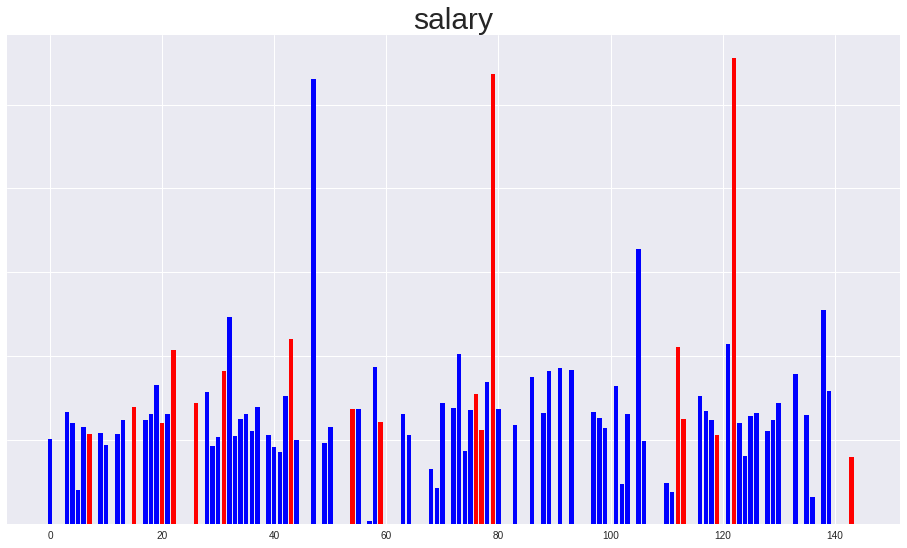

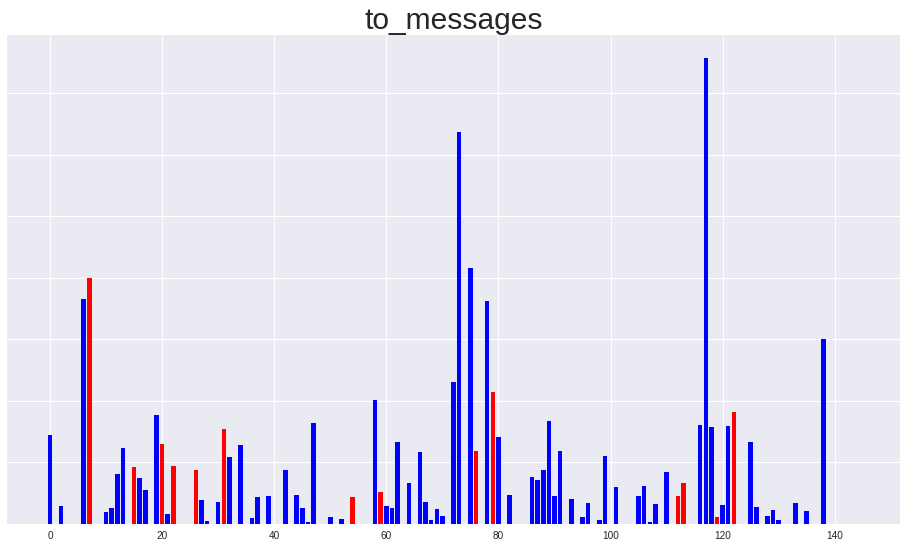

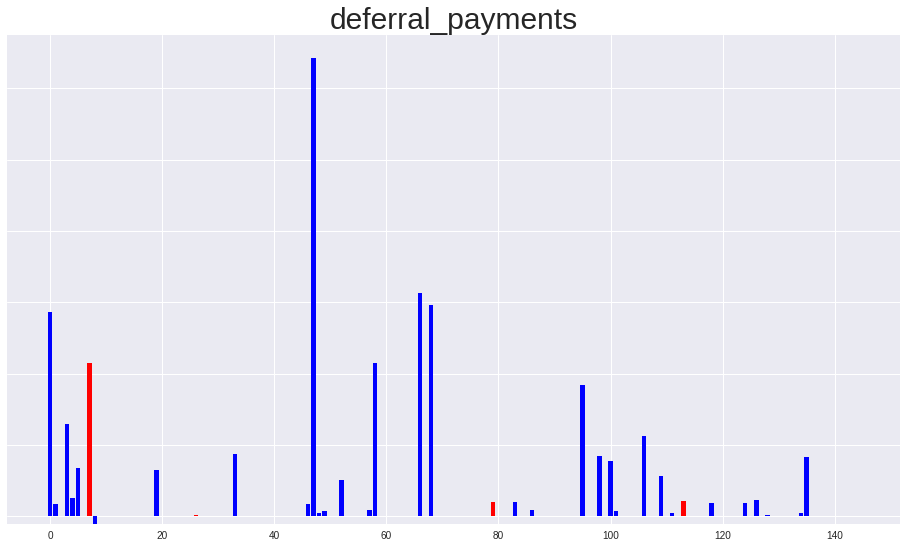

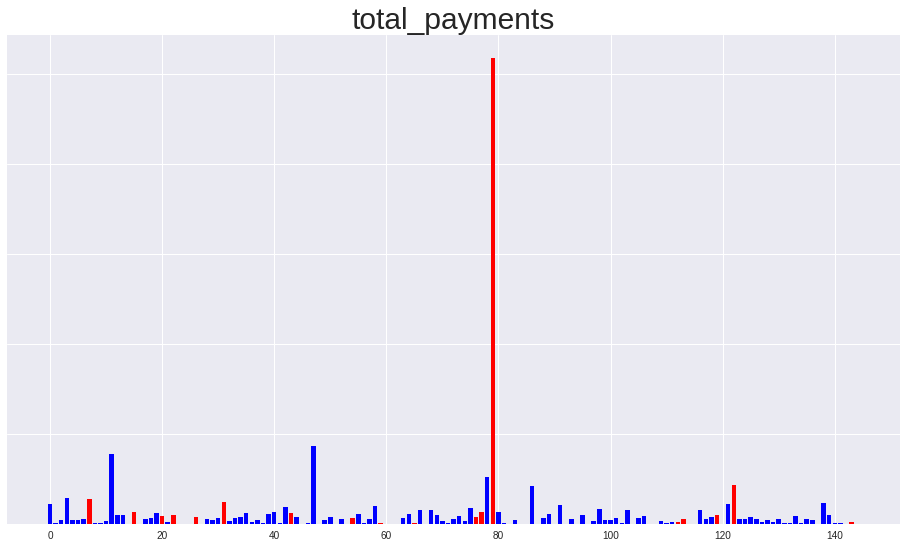

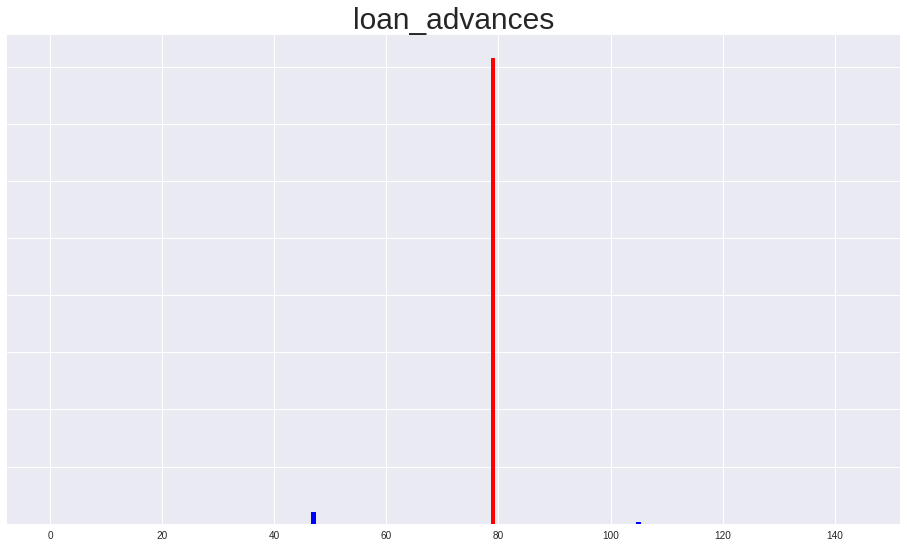

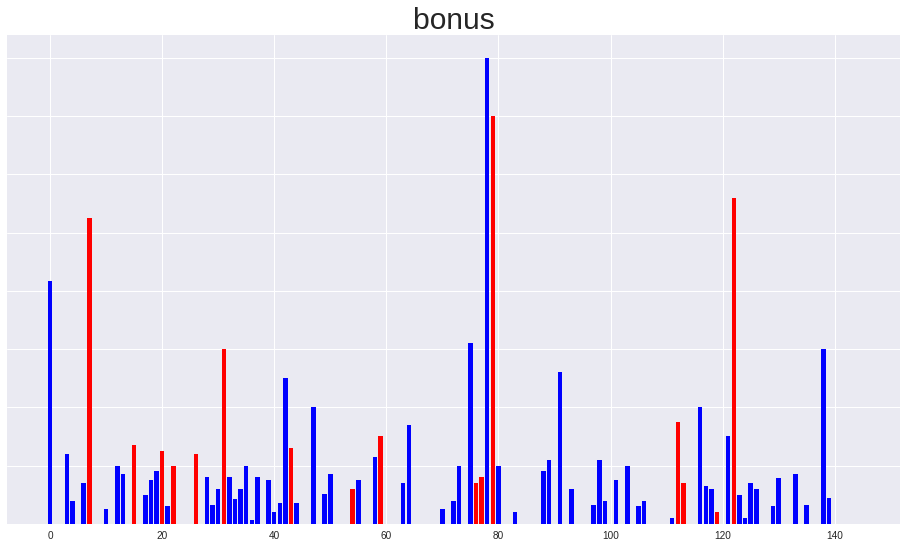

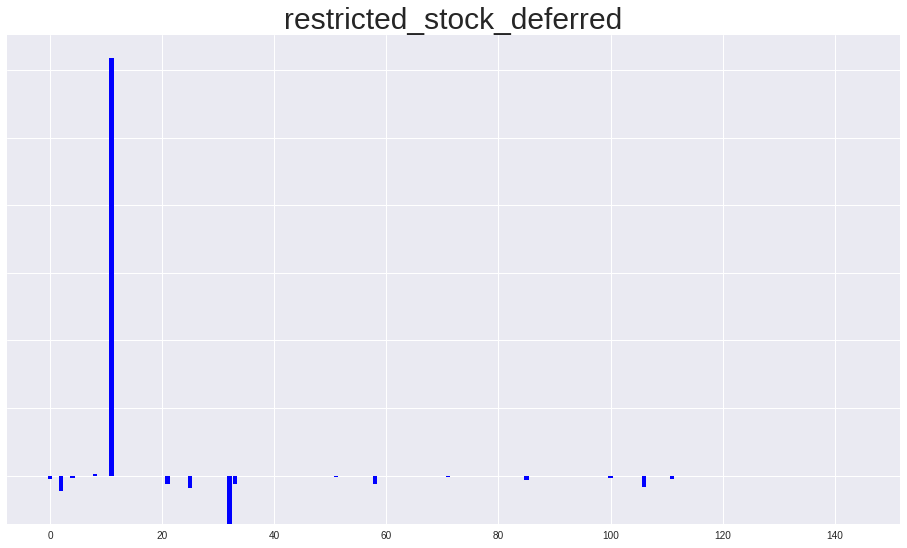

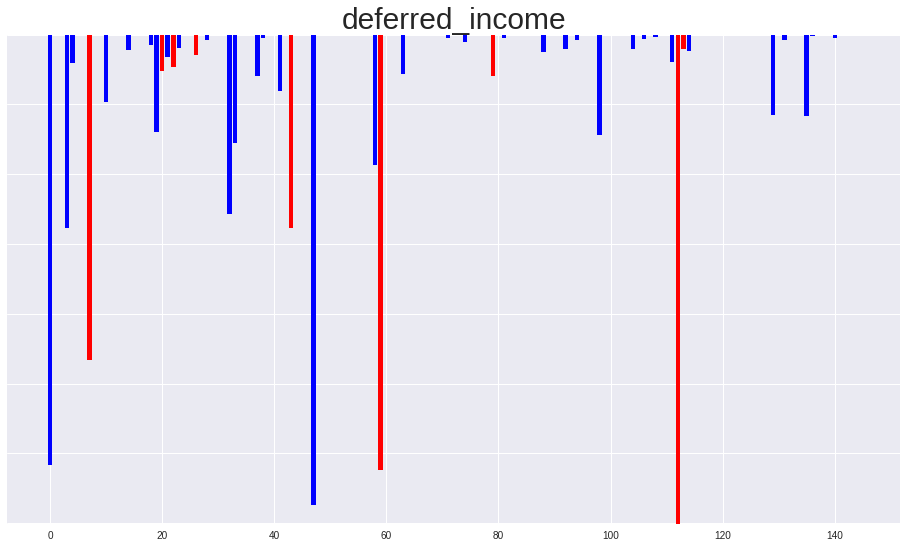

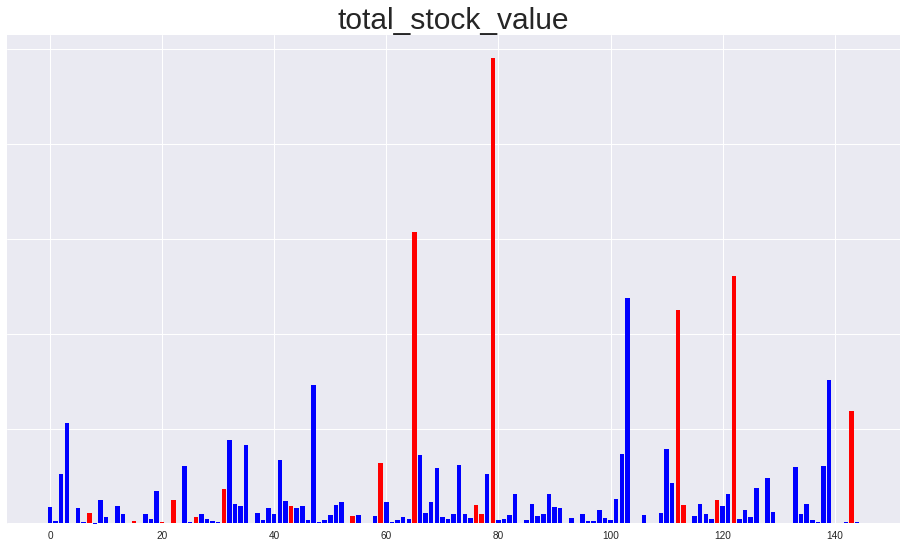

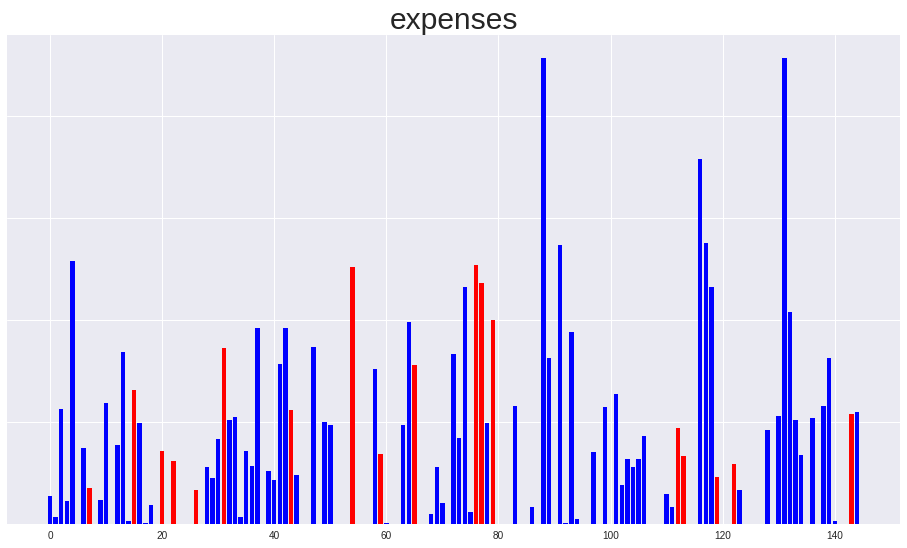

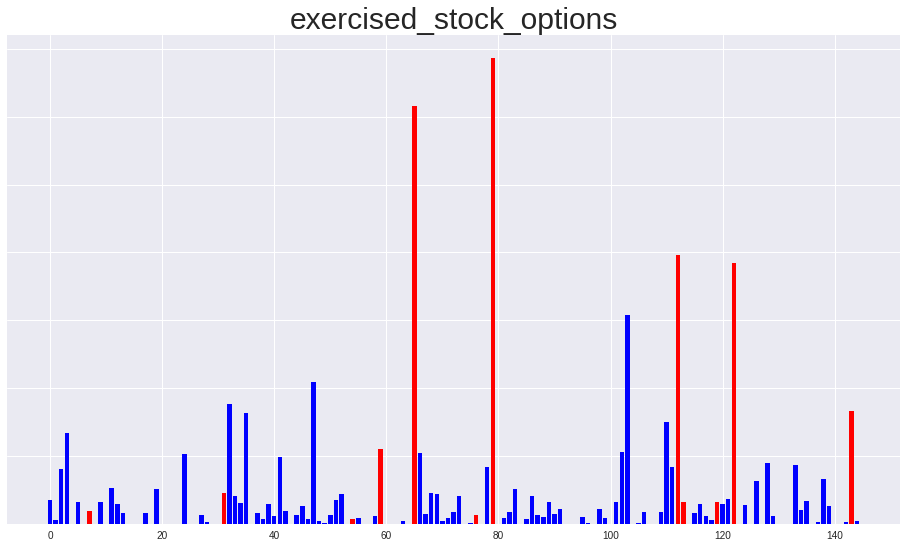

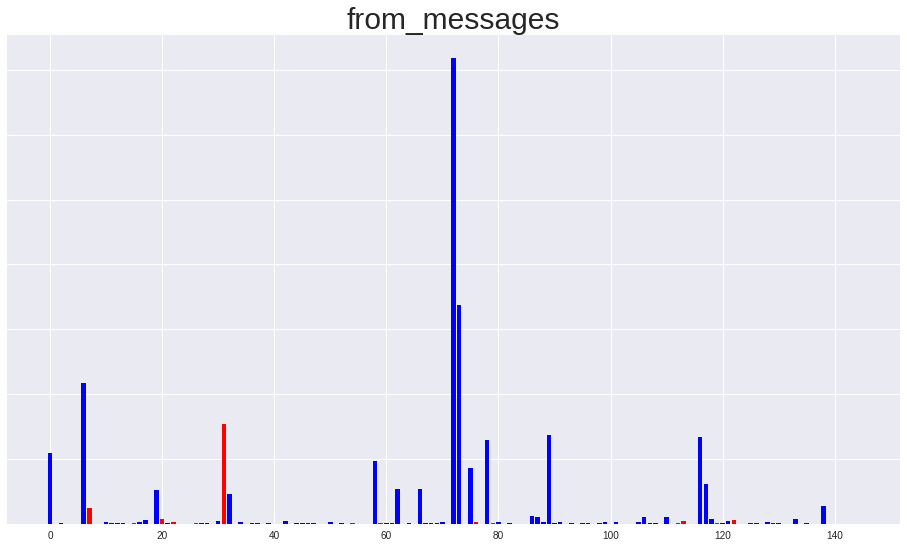

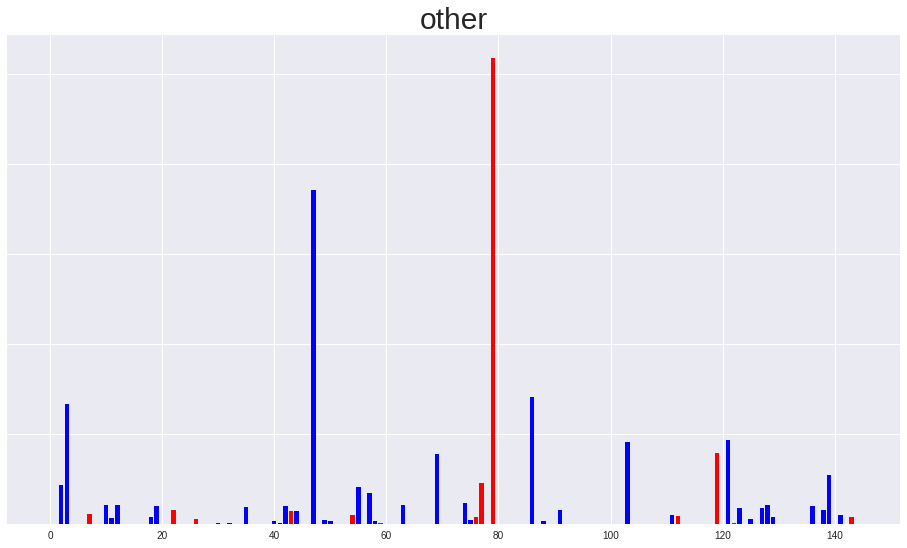

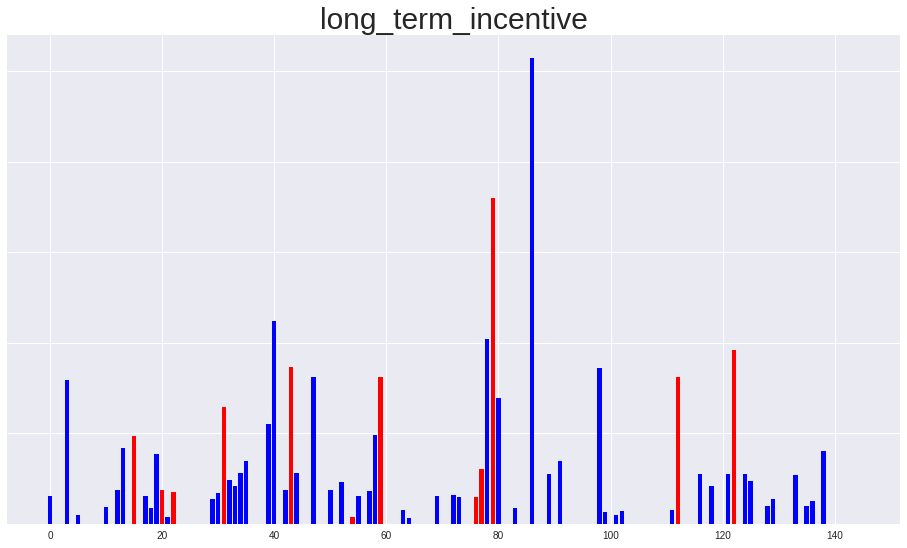

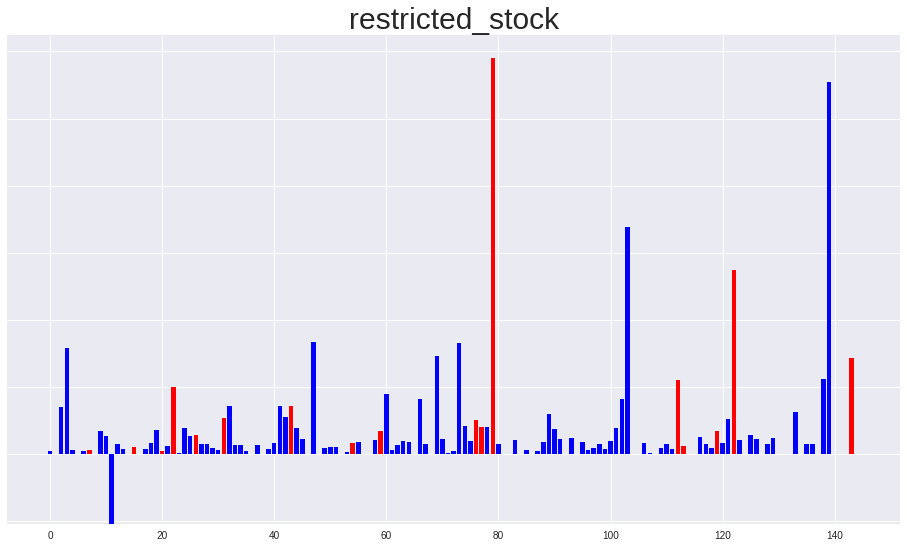

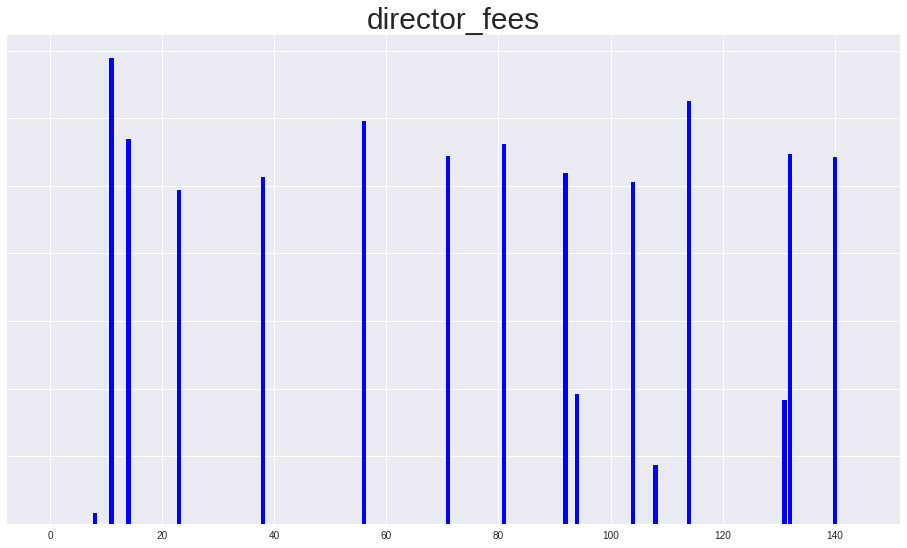

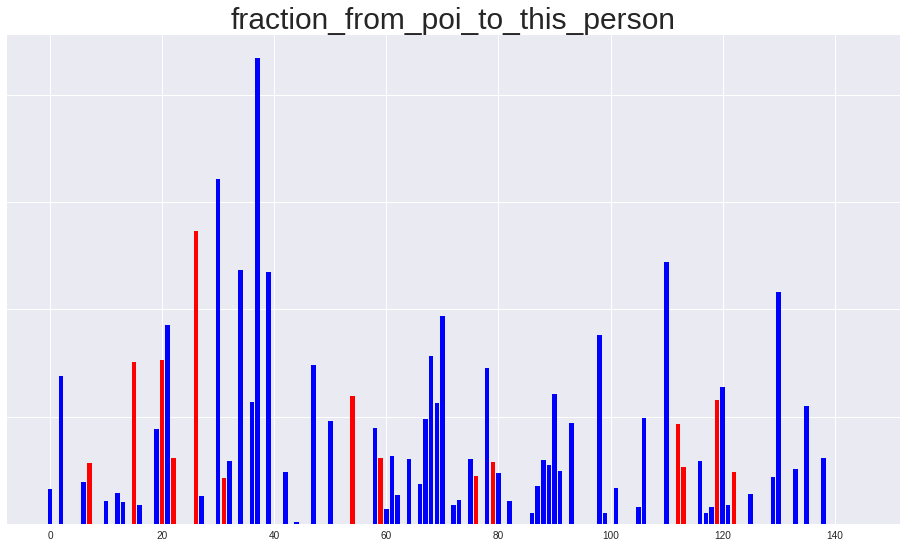

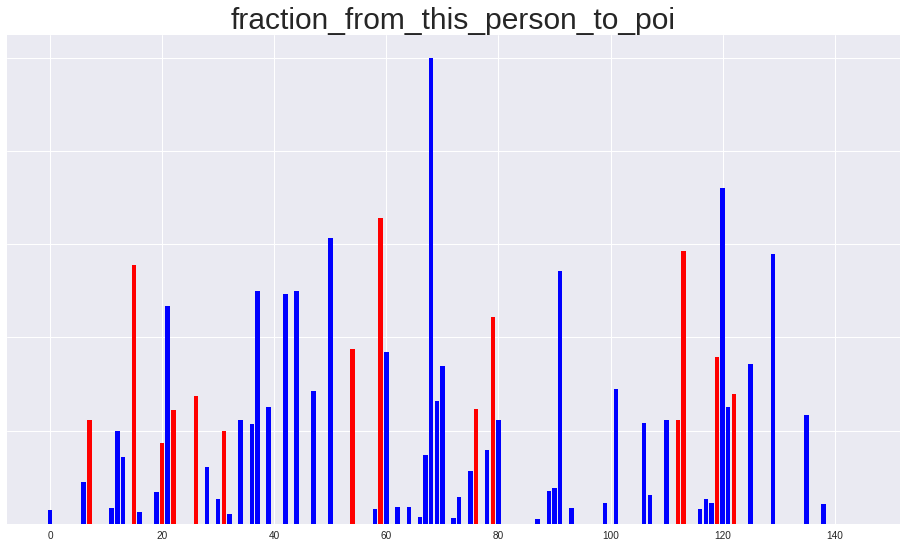

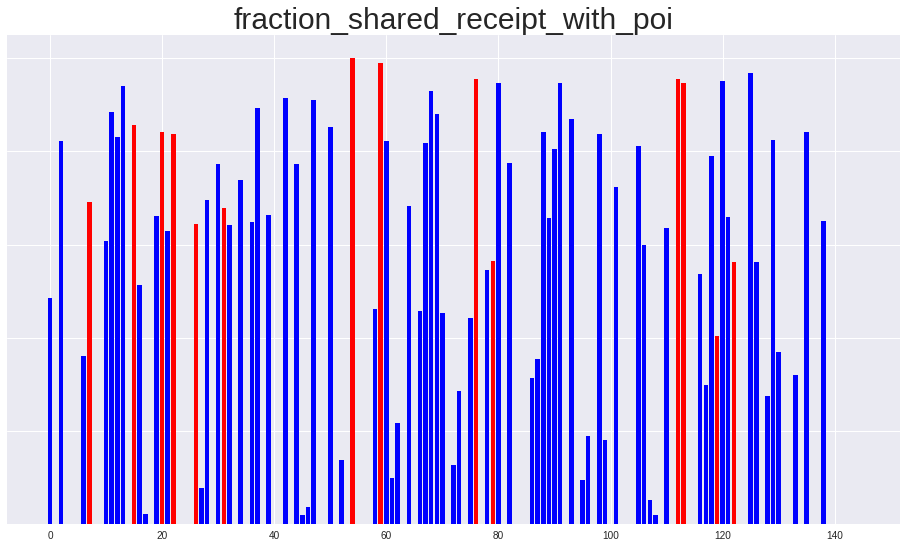

In [26]:
# use visualization to filter features.
univariate_plot(df)

From the deferred_income bar chart I find that the deferred_income should be transform to positive values so as to keep align with other features.

In [27]:
df_minmax_nan_percent_filter["deferred_income"] = df_minmax_nan_percent_filter["deferred_income"].abs()

In [28]:
classifier_shuffle_split_test(df_minmax_nan_percent_filter, features,
                              ["random_forest_classifier", "adaboost_classifier",
                               "logistic_regression_classifier", "nb_classifier",
                               "knn_classifier", "svm_classifier"])

Fitting the classifier to the training set
done in 46.039s
RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=4, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=2,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=200, n_jobs=-1, oob_score=True, random_state=42,
            verbose=0, warm_start=False)
Predicting on the training set
Done in 0.105s
             precision    recall  f1-score   support

      False       1.00      0.98      0.99        87
       True       0.88      1.00      0.93        14

avg / total       0.98      0.98      0.98       101

[[85  2]
 [ 0 14]]
Predicting on the testing set
Done in 0.104s
             precision    recall  f1-score   support

      False       0.95      0.97      0.96        40
       True       0.67      0.50      0.57         4

avg / total       0.93      0.93

After looking through the bar chart, I decide to remove 'from_messages', 'to_messages', 'total_payments' since they are
all sum, noisy and having outliers.

In [29]:
df_minmax_filter = df_minmax_nan_percent_filter.copy()
for i in ['from_messages', 'to_messages', 'total_payments']:
    features.remove(i)
    df_minmax_filter = df_minmax_filter.drop(i, axis=1)

In [30]:
classifier_test(df_minmax_filter)
# classifier_shuffle_split_test(df_minmax_filter, features)

Fitting the classifier to the training set
done in 48.777s
RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=4, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=2,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=75, n_jobs=-1, oob_score=True, random_state=42,
            verbose=0, warm_start=False)
Predicting on the training set
Done in 0.105s
             precision    recall  f1-score   support

      False       1.00      0.99      0.99        87
       True       0.93      1.00      0.97        14

avg / total       0.99      0.99      0.99       101

[[86  1]
 [ 0 14]]
Predicting on the testing set
Done in 0.109s
             precision    recall  f1-score   support

      False       0.93      1.00      0.96        40
       True       1.00      0.25      0.40         4

avg / total       0.94      0.93 

In [31]:
correlation_matrix(df, finance_features_list)

In [32]:
correlation_matrix(df, email_features_list)

From the correlation matrix we can see that "exercised_stock_options", "restricted_stock", "total_stock_value" are highly related. So I decide to use PCA to merge them into one new feature.

In [33]:
df_stock_pca = df_minmax_filter.copy()
pca = PCA(n_components=1)
df_stock_pca["stock_pca"] = pca.fit_transform(df_stock_pca[["exercised_stock_options", "restricted_stock", "total_stock_value"]])
df_stock_pca = df_stock_pca.drop(["exercised_stock_options", "restricted_stock", "total_stock_value"], axis=1)
for i in ["exercised_stock_options", "restricted_stock", "total_stock_value"]:
    features.remove(i)
features.append("stock_pca")

In [34]:
# classifier_test(df_stock_pca)
classifier_shuffle_split_test(df_stock_pca, features, ["random_forest_classifier"])

Fitting the classifier to the training set
done in 47.134s
RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=3, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=2,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=200, n_jobs=-1, oob_score=True, random_state=42,
            verbose=0, warm_start=False)
Predicting on the training set
Done in 0.105s
             precision    recall  f1-score   support

      False       1.00      0.93      0.96        87
       True       0.70      1.00      0.82        14

avg / total       0.96      0.94      0.94       101

[[81  6]
 [ 0 14]]
Predicting on the testing set
Done in 0.105s
             precision    recall  f1-score   support

      False       0.97      0.90      0.94        40
       True       0.43      0.75      0.55         4

avg / total       0.92      0.89

In [35]:
# classifier_test(df_stock_pca)
classifier_shuffle_split_test(df_stock_pca, features, ["adaboost_classifier"])

Fitting the classifier to the training set
done in 36.633s
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.25, n_estimators=50, random_state=42)
Predicting on the training set
Done in 0.009s
             precision    recall  f1-score   support

      False       0.98      1.00      0.99        87
       True       1.00      0.86      0.92        14

avg / total       0.98      0.98      0.98       101

[[87  0]
 [ 2 12]]
Predicting on the testing set
Done in 0.008s
             precision    recall  f1-score   support

      False       0.95      0.95      0.95        40
       True       0.50      0.50      0.50         4

avg / total       0.91      0.91      0.91        44

[[38  2]
 [ 2  2]]
[ 0.32  0.28  0.12  0.08  0.08  0.06  0.06  0.    0.    0.  ]
['bonus' 'other' 'stock_pca' 'expenses' 'fraction_from_this_person_to_poi'
 'salary' 'fraction_shared_receipt_with_poi' 'deferred_income'
 'long_term_incentive' 'fraction_from_poi_to_this_person'

In [36]:
classifier_shuffle_split_test(df_stock_pca, features, ["logistic_regression_classifier"])

Fitting the classifier to the training set
done in 0.087s
LogisticRegression(C=5, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
Predicting on the training set
Done in 0.000s
             precision    recall  f1-score   support

      False       0.95      0.80      0.87        87
       True       0.37      0.71      0.49        14

avg / total       0.87      0.79      0.82       101

[[70 17]
 [ 4 10]]
Predicting on the testing set
Done in 0.000s
             precision    recall  f1-score   support

      False       0.97      0.88      0.92        40
       True       0.38      0.75      0.50         4

avg / total       0.92      0.86      0.88        44

[[35  5]
 [ 1  3]]
GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight='balanced', dua

In [37]:
classifier_shuffle_split_test(df_stock_pca, features, ["nb_classifier"])

Fitting the classifier to the training set
done in 0.002s
Predicting on the training set
Done in 0.000s
             precision    recall  f1-score   support

      False       0.90      0.91      0.90        87
       True       0.38      0.36      0.37        14

avg / total       0.83      0.83      0.83       101

[[79  8]
 [ 9  5]]
Predicting on the testing set
Done in 0.000s
             precision    recall  f1-score   support

      False       0.95      0.93      0.94        40
       True       0.40      0.50      0.44         4

avg / total       0.90      0.89      0.89        44

[[37  3]
 [ 2  2]]
GaussianNB(priors=None)
	Accuracy: 0.83073	Precision: 0.34609	Recall: 0.30300	F1: 0.32311	F2: 0.31074
	Total predictions: 15000	True positives:  606	False positives: 1145	False negatives: 1394	True negatives: 11855



In [38]:
classifier_shuffle_split_test(df_stock_pca, features, ["svm_classifier"])

Fitting the classifier to the training set
done in 0.489s
Best estimator found by grid search:
SVC(C=0.5, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Predicting on the training set
Done in 0.001s
             precision    recall  f1-score   support

      False       0.93      0.76      0.84        87
       True       0.30      0.64      0.41        14

avg / total       0.84      0.74      0.78       101

[[66 21]
 [ 5  9]]
Predicting on the testing set
Done in 0.001s
             precision    recall  f1-score   support

      False       1.00      0.75      0.86        40
       True       0.29      1.00      0.44         4

avg / total       0.94      0.77      0.82        44

[[30 10]
 [ 0  4]]
GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=

In [39]:
classifier_shuffle_split_test(df_stock_pca, features, ["knn_classifier"])

Fitting the classifier to the training set
done in 0.217s
Best estimator found by grid search:
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')
Predicting on the training set
Done in 0.002s
             precision    recall  f1-score   support

      False       0.88      1.00      0.94        87
       True       1.00      0.14      0.25        14

avg / total       0.90      0.88      0.84       101

[[87  0]
 [12  2]]
Predicting on the testing set
Done in 0.001s
             precision    recall  f1-score   support

      False       0.91      0.97      0.94        40
       True       0.00      0.00      0.00         4

avg / total       0.82      0.89      0.85        44

[[39  1]
 [ 4  0]]
GridSearchCV(cv=None, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighb

I noticed that both long_term_incentive and deferred_income are appeared on the last three importances in both random forest and adaboost.
Consequently and last but not least, I remove them and make final features.

In [40]:
selected_features = ['bonus', 'expenses', 'salary', 'deferred_income', 'other',
       'long_term_incentive', 'fraction_from_poi_to_this_person',
       'fraction_from_this_person_to_poi',
       'fraction_shared_receipt_with_poi', 'stock_pca']

In [41]:
df_select_feature = df_stock_pca.copy()
for i in ['deferred_income', 'long_term_incentive']:
    selected_features.remove(i)
    df_select_feature = df_select_feature.drop(i, axis=1)

In [42]:
classifier_shuffle_split_test(df_select_feature, selected_features, ["random_forest_classifier"])

Fitting the classifier to the training set
done in 44.293s
RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=3, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=2,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=150, n_jobs=-1, oob_score=True, random_state=42,
            verbose=0, warm_start=False)
Predicting on the training set
Done in 0.108s
             precision    recall  f1-score   support

      False       1.00      0.95      0.98        87
       True       0.78      1.00      0.88        14

avg / total       0.97      0.96      0.96       101

[[83  4]
 [ 0 14]]
Predicting on the testing set
Done in 0.109s
             precision    recall  f1-score   support

      False       0.97      0.90      0.94        40
       True       0.43      0.75      0.55         4

avg / total       0.92      0.89

In [43]:
classifier_shuffle_split_test(df_select_feature, selected_features, ["adaboost_classifier"])

Fitting the classifier to the training set
done in 40.934s
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.25, n_estimators=125, random_state=42)
Predicting on the training set
Done in 0.021s
             precision    recall  f1-score   support

      False       1.00      1.00      1.00        87
       True       1.00      1.00      1.00        14

avg / total       1.00      1.00      1.00       101

[[87  0]
 [ 0 14]]
Predicting on the testing set
Done in 0.021s
             precision    recall  f1-score   support

      False       0.95      0.90      0.92        40
       True       0.33      0.50      0.40         4

avg / total       0.89      0.86      0.88        44

[[36  4]
 [ 2  2]]
[ 0.24   0.168  0.152  0.112  0.088  0.088  0.08   0.072]
['salary' 'stock_pca' 'other' 'bonus' 'fraction_from_poi_to_this_person'
 'fraction_shared_receipt_with_poi' 'expenses'
 'fraction_from_this_person_to_poi']
AdaBoostClassifier(algorithm='SAMME.R', b

In [44]:
classifier_shuffle_split_test(df_select_feature, selected_features, ["logistic_regression_classifier"])

Fitting the classifier to the training set
done in 0.109s
LogisticRegression(C=10, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
Predicting on the training set
Done in 0.000s
             precision    recall  f1-score   support

      False       0.93      0.79      0.86        87
       True       0.33      0.64      0.44        14

avg / total       0.85      0.77      0.80       101

[[69 18]
 [ 5  9]]
Predicting on the testing set
Done in 0.000s
             precision    recall  f1-score   support

      False       0.97      0.82      0.89        40
       True       0.30      0.75      0.43         4

avg / total       0.91      0.82      0.85        44

[[33  7]
 [ 1  3]]
GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight='balanced', du

In [45]:
classifier_shuffle_split_test(df_select_feature, selected_features, ["svm_classifier"])

Fitting the classifier to the training set
done in 1.026s
Best estimator found by grid search:
SVC(C=0.5, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Predicting on the training set
Done in 0.001s
             precision    recall  f1-score   support

      False       0.93      0.72      0.81        87
       True       0.27      0.64      0.38        14

avg / total       0.84      0.71      0.75       101

[[63 24]
 [ 5  9]]
Predicting on the testing set
Done in 0.002s
             precision    recall  f1-score   support

      False       1.00      0.72      0.84        40
       True       0.27      1.00      0.42         4

avg / total       0.93      0.75      0.80        44

[[29 11]
 [ 0  4]]
GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=

In [46]:
classifier_shuffle_split_test(df_select_feature, selected_features, ["nb_classifier"])

Fitting the classifier to the training set
done in 0.002s
Predicting on the training set
Done in 0.001s
             precision    recall  f1-score   support

      False       0.90      0.92      0.91        87
       True       0.42      0.36      0.38        14

avg / total       0.83      0.84      0.84       101

[[80  7]
 [ 9  5]]
Predicting on the testing set
Done in 0.000s
             precision    recall  f1-score   support

      False       0.95      0.93      0.94        40
       True       0.40      0.50      0.44         4

avg / total       0.90      0.89      0.89        44

[[37  3]
 [ 2  2]]
GaussianNB(priors=None)
	Accuracy: 0.83007	Precision: 0.32482	Recall: 0.25450	F1: 0.28539	F2: 0.26602
	Total predictions: 15000	True positives:  509	False positives: 1058	False negatives: 1491	True negatives: 11942



In [47]:
classifier_shuffle_split_test(df_select_feature, selected_features, ["knn_classifier"])

Fitting the classifier to the training set
done in 0.226s
Best estimator found by grid search:
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')
Predicting on the training set
Done in 0.001s
             precision    recall  f1-score   support

      False       0.88      0.98      0.92        87
       True       0.50      0.14      0.22        14

avg / total       0.82      0.86      0.83       101

[[85  2]
 [12  2]]
Predicting on the testing set
Done in 0.001s
             precision    recall  f1-score   support

      False       0.91      0.97      0.94        40
       True       0.00      0.00      0.00         4

avg / total       0.82      0.89      0.85        44

[[39  1]
 [ 4  0]]
GridSearchCV(cv=None, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighb

In [48]:
clf = random_forest_classifier(df_select_feature)
my_dataset = df_select_feature.to_dict(orient="index")
features_list = ["poi"] + selected_features

Fitting the classifier to the training set
done in 46.781s
RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=3, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=2,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=200, n_jobs=-1, oob_score=True, random_state=42,
            verbose=0, warm_start=False)
Predicting on the training set
Done in 0.104s
             precision    recall  f1-score   support

      False       1.00      0.93      0.96        87
       True       0.70      1.00      0.82        14

avg / total       0.96      0.94      0.94       101

[[81  6]
 [ 0 14]]
Predicting on the testing set
Done in 0.104s
             precision    recall  f1-score   support

      False       0.97      0.90      0.94        40
       True       0.43      0.75      0.55         4

avg / total       0.92      0.89

In [49]:
# Task 6: Dump your classifier, dataset, and features_list so anyone can
# check your results. You do not need to change anything below, but make sure
# that the version of poi_id.py that you submit can be run on its own and
# generates the necessary .pkl files for validating your results.
dump_classifier_and_data(clf, my_dataset, features_list)